<a href="https://colab.research.google.com/github/yasinunsal/INM706/blob/main/FasterRCNN_448_448.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!ls

05180000029.ipynb				     Untitled
FasterRCNN_112_112_faster_weights.ipynb		     Untitled0.ipynb
FasterRCNN_112_112.ipynb			     Untitled1.ipynb
FasterRCNN_112_112_mobilenet_v3_large_320_fpn.ipynb  Untitled2.ipynb
FasterRCNN_224_224.ipynb			     Untitled3.ipynb
FasterRCNN_448_448.ipynb			     Untitled4.ipynb
fruit-images-for-object-detection		     Untitled6.ipynb
INM702-Task2.ipynb				     wandb


In [17]:
%cd /content/drive/MyDrive/Colab\ Notebooks
!ls


/content/drive/MyDrive/Colab Notebooks
05180000029.ipynb				     Untitled
FasterRCNN_112_112_faster_weights.ipynb		     Untitled0.ipynb
FasterRCNN_112_112.ipynb			     Untitled1.ipynb
FasterRCNN_112_112_mobilenet_v3_large_320_fpn.ipynb  Untitled2.ipynb
FasterRCNN_224_224.ipynb			     Untitled3.ipynb
FasterRCNN_448_448.ipynb			     Untitled4.ipynb
fruit-images-for-object-detection		     Untitled6.ipynb
INM702-Task2.ipynb				     wandb


In [18]:
! python --version

Python 3.10.12


In [19]:
!pip install -q torch_snippets
!pip install wandb -qU
from torch_snippets import *
import torch
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
import numpy as np
import wandb
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)



cuda

In [20]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [21]:
root = 'fruit-images-for-object-detection/train_zip/train/'

# we have four labels
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [22]:
wandb.login()
wandb.init(project='faster_rcnn_448_448')



In [23]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.to(device).float()

class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        w, h = 448, 448
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h), resample=Image.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

val_root = 'fruit-images-for-object-detection/test_zip/test/'

tr_ds = FruitsDataset()
tr_dl = DataLoader(tr_ds, batch_size=4, shuffle=True, collate_fn=tr_ds.collate_fn)

val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn)


In [24]:
def get_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #print(in_features)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model



# test the model
imgs, targets = next(iter(tr_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
model(imgs, targets)


{'loss_classifier': tensor(1.6350, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.3368, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0029, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)}

In [25]:
model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=5e-4, momentum=0.9)

def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optim.step()


    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=5e-4, momentum=0.9)




EPOCH: 0.017  trn_loss: 1.594  trn_loc_loss: 1.348  trn_regr_loss: 0.234  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.008  (0.40s - 120.45s remaining)
EPOCH: 0.033  trn_loss: 0.589  trn_loc_loss: 0.366  trn_regr_loss: 0.216  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.005  (0.80s - 119.30s remaining)
EPOCH: 0.050  trn_loss: 0.527  trn_loc_loss: 0.279  trn_regr_loss: 0.240  trn_loss_objectness: 0.002  trn_loss_rpn_box_reg: 0.006  (1.22s - 120.64s remaining)
EPOCH: 0.067  trn_loss: 0.434  trn_loc_loss: 0.242  trn_regr_loss: 0.170  trn_loss_objectness: 0.016  trn_loss_rpn_box_reg: 0.006  (1.63s - 120.52s remaining)
EPOCH: 0.083  trn_loss: 0.729  trn_loc_loss: 0.450  trn_regr_loss: 0.273  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.003  (2.03s - 119.67s remaining)
EPOCH: 0.100  trn_loss: 0.770  trn_loc_loss: 0.449  trn_regr_loss: 0.310  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.006  (2.41s - 118.13s remaining)
EPOCH: 0.117  trn_loss: 0.660  trn_loc_loss: 0

100%|██████████| 106/106 [00:00<00:00, 7127.00it/s]


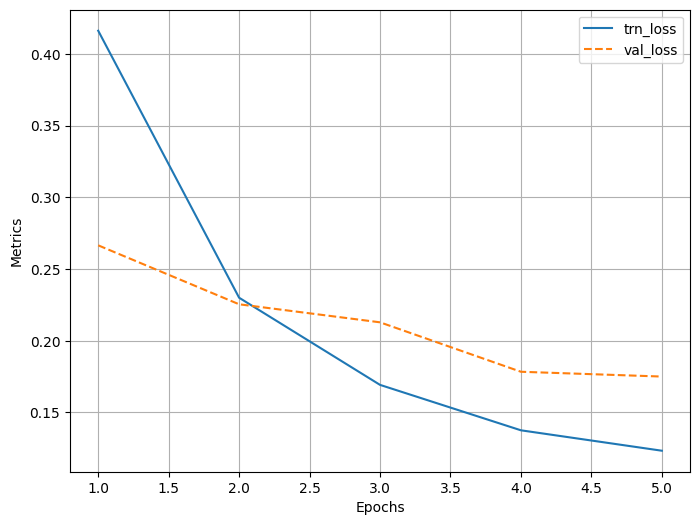

trn_loc_loss,▄█▃▃▂▅▃▂▂▂▂▁▁▂▂▃▁▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁
trn_loss,▄█▄▄▂▆▃▂▃▃▂▁▁▂▂▃▂▁▂▂▂▃▂▂▂▁▂▁▂▂▂▁▂▁▂▂▂▁▂▁
trn_loss_objectness,▇▄▃█▃▆▃▄▄▂▁▃▁▃▅▃▁▃▁▁▂▃▁▁▃▁▃▁▁▂▁▁▁▂▁▂▁▁▁▁
trn_loss_rpn_box_reg,▂▃▄█▂▄▂▃▂▁▂▁▁▁▂▄▁▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▂▂▂▂▁
trn_regr_loss,▃█▅▄▃▇▃▃▃▃▂▂▂▃▂▄▂▁▂▂▃▃▃▂▂▂▂▁▂▃▂▂▃▁▂▃▃▂▃▁
val_loc_loss,▂▂▃▃▇▂▇█▃▁▅▃▃▃▃▃▁▃▂▂▃▄█▅▂▂▁▃▄▁▂▂▂▃▃▁▂▂▆▂
val_loss,▂▂▂▃▇▂██▄▂▅▃▄▄▃▄▂▄▂▂▃▅█▄▃▂▁▄▅▁▃▂▂▃▃▁▂▂▇▃
val_loss_objectness,▁▂▁▁▇▃█▇▂▂▃▃▃▂▁▃▁▆▂▂▃▃▃▂▂▃▁▇▃▁▂▂▂▁▁▃▂▂▅▂
val_loss_rpn_box_reg,▂▂▂▁▃▃▃▂▂▃▂▂▅▃▄▃▂▃▁▃▂▂▂▂█▂▁▄▂▁▂▃▁▂▂▁▂▁▄▂
val_regr_loss,▂▂▂▂▆▁▇█▄▂▆▄▄▅▃▅▂▅▂▂▄▅▇▄▃▂▁▄▆▁▃▃▂▃▄▁▁▂█▃
trn_loc_loss,0.01017


In [26]:
n_epochs = 5
log = Report(n_epochs)
# Inside training loop
for e in range(n_epochs):
    for i, batch in enumerate(tr_dl):
        N = len(tr_dl)
        loss, losses = train_batch(batch, model, optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_loss_objectness=loss_objectness.item(),
                   trn_loss_rpn_box_reg = loss_rpn_box_reg.item())
        # Log metrics with wandb
        wandb.log({
            'trn_loss': loss,
            'trn_loc_loss': loc_loss,
            'trn_regr_loss': regr_loss,
            'trn_loss_objectness': loss_objectness,
            'trn_loss_rpn_box_reg': loss_rpn_box_reg
        })

    # Validation loop
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model.float(), optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg',
                                                                   'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_loss_objectness=loss_objectness.item(),
                   val_loss_rpn_box_reg = loss_rpn_box_reg.item())
        # Log metrics with wandb
        wandb.log({
            'val_loss': loss,
            'val_loc_loss': loc_loss,
            'val_regr_loss': regr_loss,
            'val_loss_objectness': loss_objectness,
            'val_loss_rpn_box_reg': loss_rpn_box_reg
        })

    log.report_avgs(e+1)

    ##wandb.summary['test_accuracy'] = 0.8
log.plot_epochs(['trn_loss', 'val_loss'])
wandb.finish()

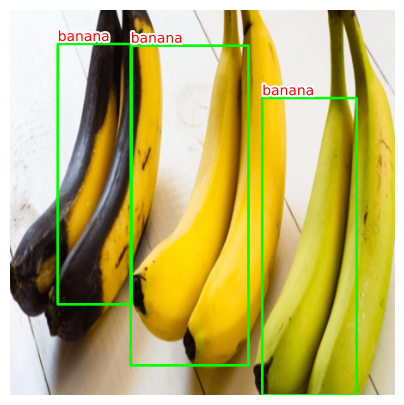

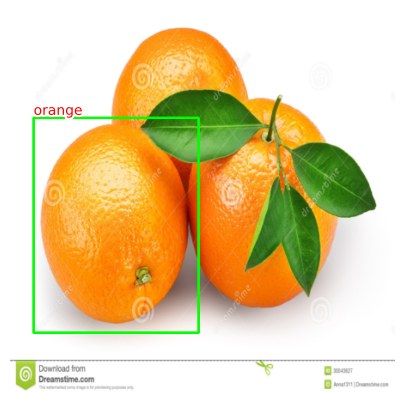

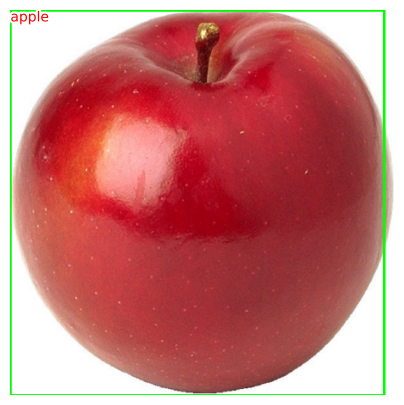

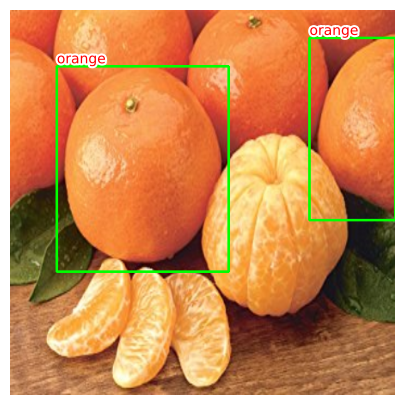

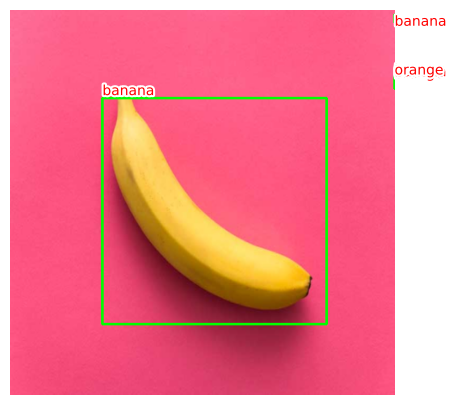

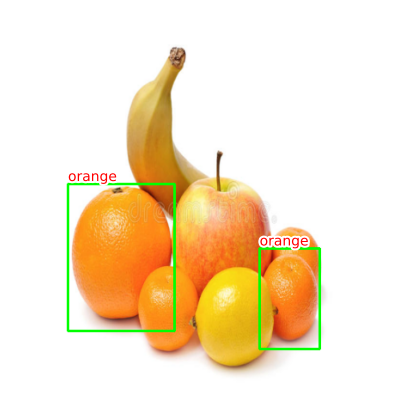

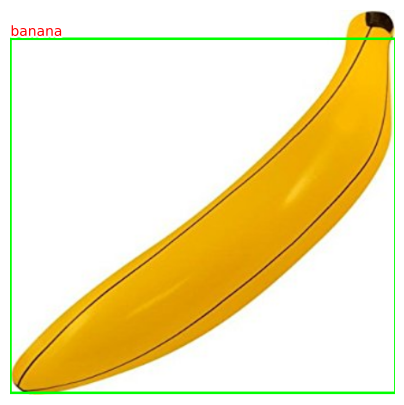

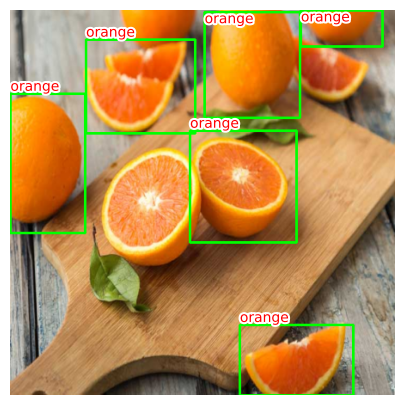

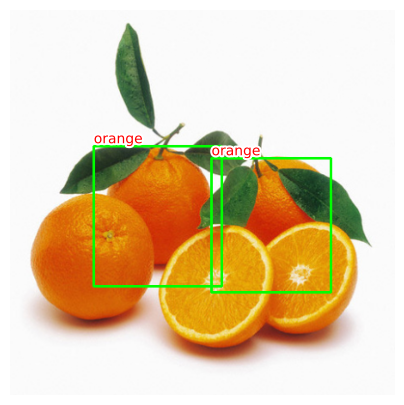

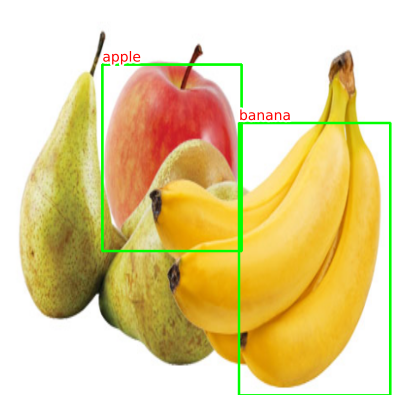

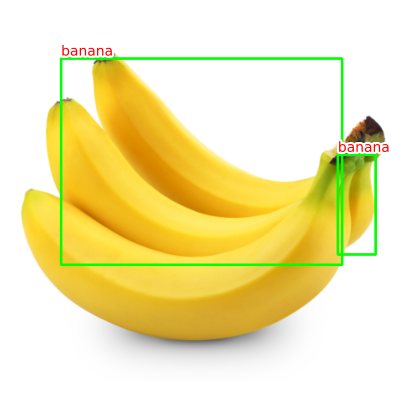

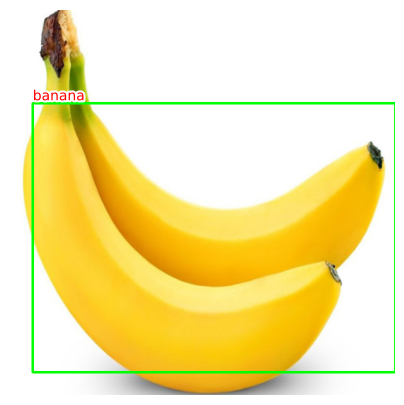

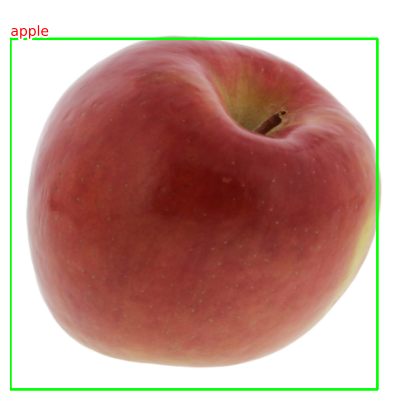

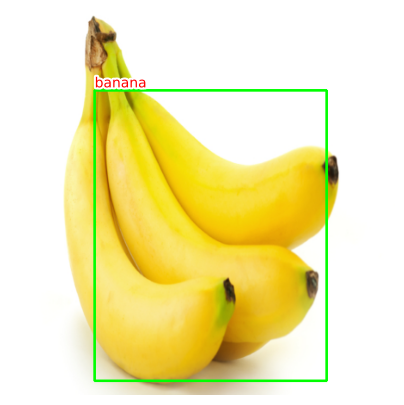

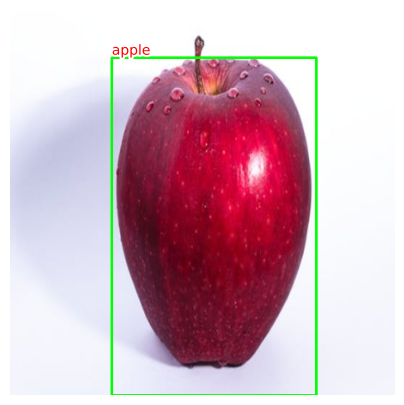

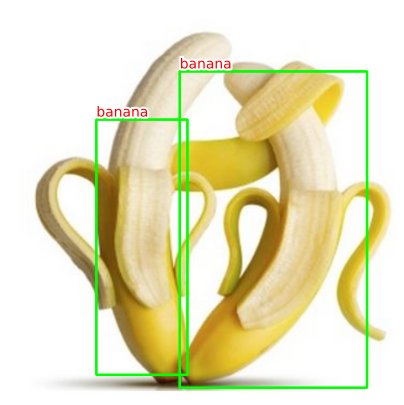

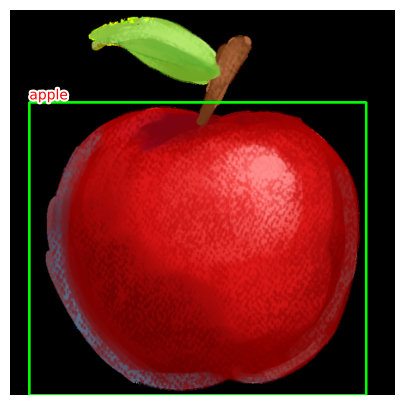

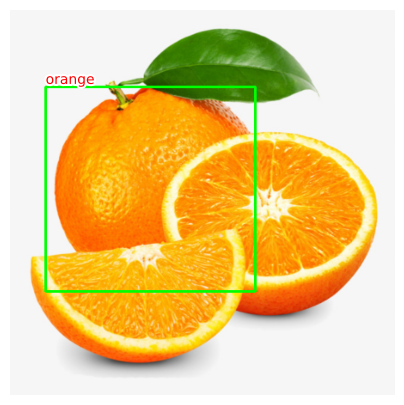

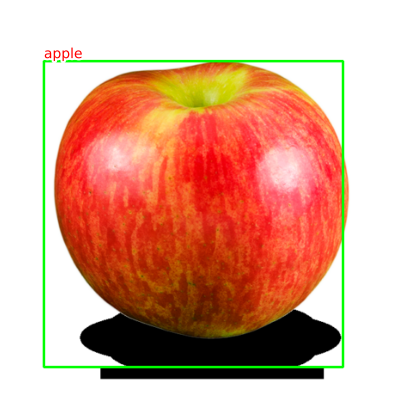

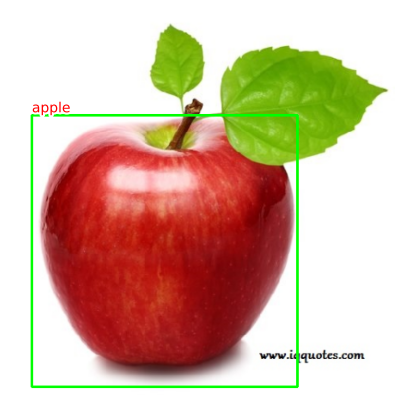

In [27]:
from torchvision.ops import nms

def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for i, (images, targets) in enumerate(val_dl):
    if i == 10: break
    images = [im for im in images]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        show(images[i].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5, text_sz=10)